In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import shap
from sklearn.compose import ColumnTransformer

df = pd.read_csv("BMW_Car_Sales_Classification.csv")
df.head()

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [4]:
# Convertir variables de tipo object a category
df['Model'] = df['Model'].astype('category')
df['Region'] = df['Region'].astype('category')
df['Color'] = df['Color'].astype('category')
df['Fuel_Type'] = df['Fuel_Type'].astype('category')
df['Transmission'] = df['Transmission'].astype('category')
df['Sales_Classification'] = df['Sales_Classification'].astype('category')

# Verificamos cambios
print(df.dtypes)

Model                   category
Year                       int64
Region                  category
Color                   category
Fuel_Type               category
Transmission            category
Engine_Size_L            float64
Mileage_KM                 int64
Price_USD                  int64
Sales_Volume               int64
Sales_Classification    category
dtype: object


In [5]:
# Aplicar One-Hot Encoding
df = pd.get_dummies(df, drop_first=True)

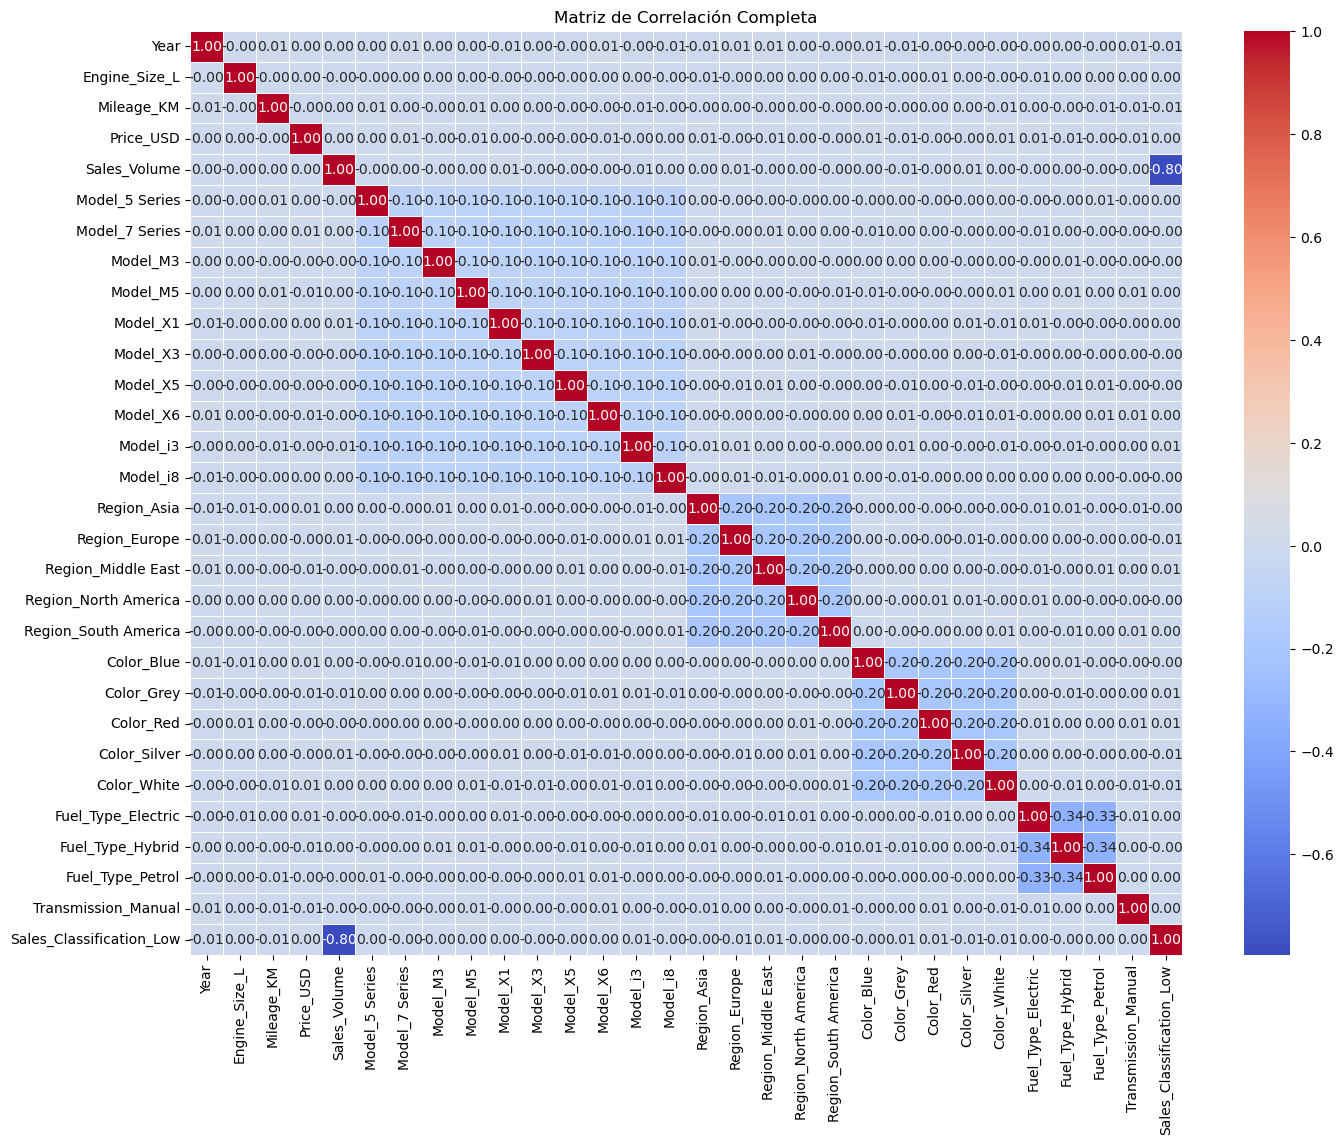

In [6]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(16, 12))  # Ajusta el tamaño según tu número de variables
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación Completa")
plt.show()

In [7]:
# Separar variables predictoras (X) y variable objetivo (y)
X = df.drop('Sales_Classification_Low', axis=1)
y = df['Sales_Classification_Low']

In [8]:
# Dividir train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# Verificar las formas de los conjuntos
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35000, 29) (15000, 29) (35000,) (15000,)


In [10]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

C:\Users\Sergio\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:11:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
#Evaluar modelo
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 4536     8]
 [    4 10452]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4544
        True       1.00      1.00      1.00     10456

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



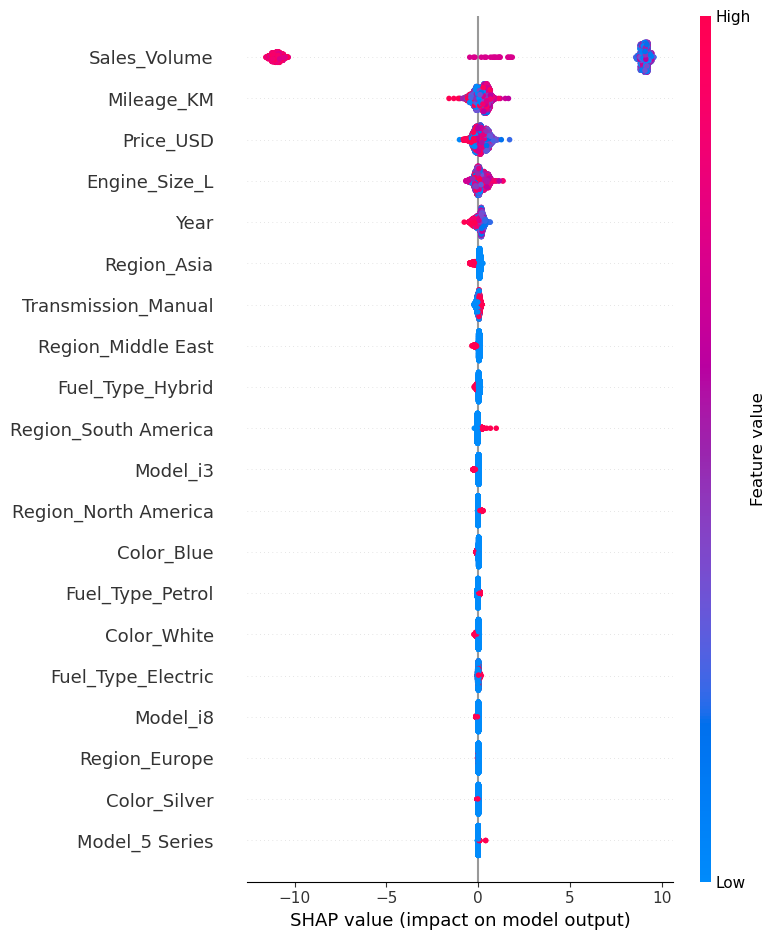

In [13]:
# Crear explainer usando TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# Calcular shap_values para X_test
# Para evitar overflow o lentitud, podemos tomar un submuestreo
X_sample = X_test.sample(5000, random_state=42)  # si el dataset es muy grande
shap_values = explainer.shap_values(X_sample)

# Graficar resumen global para la clase positiva
shap.summary_plot(shap_values, X_sample, feature_names=X_sample.columns)

In [ ]:
--------------------------------------------------------------------------------------------------------------------

In [14]:
#Dopear variable con alta correlación
X_train_drop = X_train.drop(columns=['Sales_Volume'])
X_test_drop = X_test.drop(columns=['Sales_Volume'])

In [15]:
from xgboost import XGBClassifier

xgb_model_drop = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model_drop.fit(X_train_drop, y_train)

C:\Users\Sergio\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:15:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_drop = xgb_model_drop.predict(X_test_drop)

print(confusion_matrix(y_test, y_pred_drop))
print(classification_report(y_test, y_pred_drop))

[[  190  4354]
 [  449 10007]]
              precision    recall  f1-score   support

       False       0.30      0.04      0.07      4544
        True       0.70      0.96      0.81     10456

    accuracy                           0.68     15000
   macro avg       0.50      0.50      0.44     15000
weighted avg       0.58      0.68      0.58     15000



In [18]:
X_train_drop = X_train_drop.astype('float64')
X_test_drop = X_test_drop.astype('float64')

 96%|=================== | 14420/15000 [00:23<00:00]       

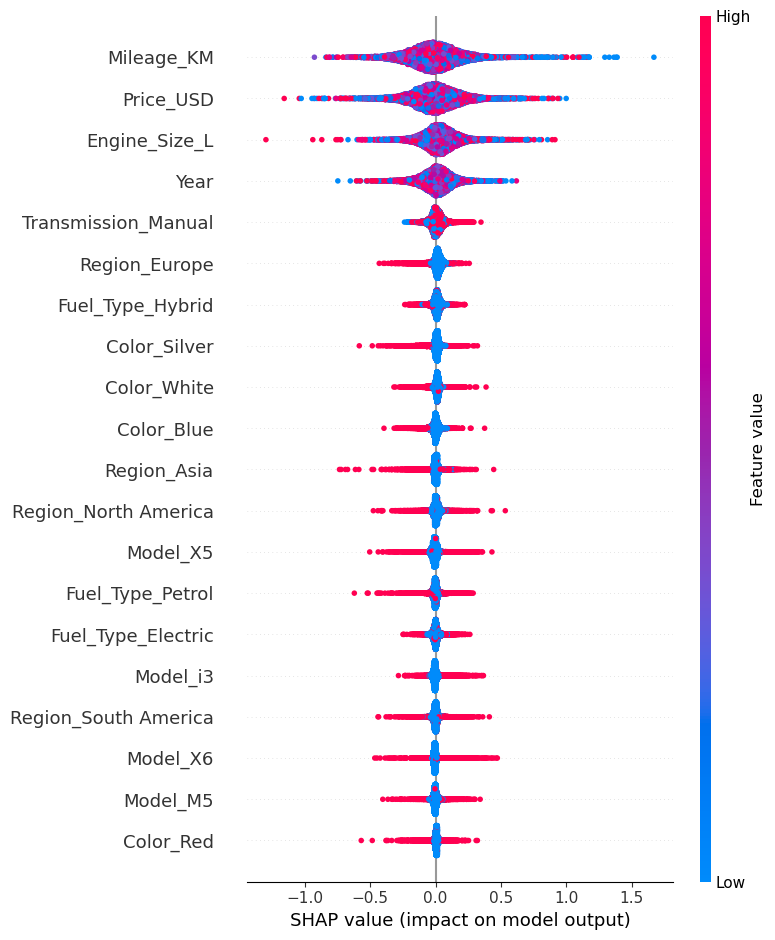

In [19]:
import shap

explainer_drop = shap.Explainer(xgb_model_drop, X_train_drop)
shap_values_drop = explainer_drop(X_test_drop)

shap.summary_plot(shap_values_drop, X_test_drop)

In [ ]:
Una radiografía clara de qué variables están empujando al modelo a clasificar un coche como de ventas altas (“High”), 
especialmente ahora que sabemos que el modelo tiene una tasa de acierto altísima en esa clase.

- Cada punto representa un coche, y su posición en el eje horizontal indica cuánto contribuye esa variable a que el modelo prediga “High”.
- Los colores te dicen si el valor de la variable es alto (🔴) o bajo (🔵).
- Las variables más arriba en el gráfico son las que más influyen en la decisión del modelo.

- Si Mileage_KM aparece como influyente y los puntos rojos están a la izquierda (SHAP negativo), eso sugiere que alto kilometraje reduce la probabilidad de ventas altas.
- Si Price_USD tiene puntos rojos a la derecha, entonces precios altos podrían estar asociados a ventas altas, dependiendo del contexto del mercado.

